# Classification de Chiffres Manuscrits avec Réseaux de Neurones Convolutifs (CNN) sur le jeu de données MNIST

##  Prise en main du jeu de données MNIST

Ces importations chargent des bibliothèques nécessaires pour créer, entraîner, sauvegarder et charger des modèles de réseaux de neurones en utilisant TensorFlow et Keras, ainsi que pour visualiser des données avec Matplotlib et manipuler des tableaux numériques avec NumPy.

In [21]:
import tensorflow as tf
from tensorflow.keras.models import load_model, save_model
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D, Flatten, Input, BatchNormalization
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

Ce code charge le jeu de données MNIST depuis TensorFlow, prépare les images pour un modèle de réseau de neurones convolutif (CNN) et affiche les dimensions des ensembles de données d'entraînement et de test.

In [2]:
# Chargement du jeu de données MNIST depuis TensorFlow Keras datasets
mnist = tf.keras.datasets.mnist  

# Chargement des données d'entraînement (X_train contient les images, y_train contient les labels)
# Chargement des données de test (X_test contient les images, y_test contient les labels)
(X_train, y_train), (X_test, y_test) = mnist.load_data()  

# Remodelage des données d'entraînement et de test pour les adapter au modèle CNN 
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')  
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')  

# Affichage des dimensions des données d'entraînement et de test
print("Shape of X_train:", X_train.shape)  # Affiche la forme de X_train (nombre d'images, largeur, hauteur, canal)
print("Shape of y_train:", y_train.shape)  # Affiche la forme de y_train (nombre d'images d'entraînement)
print("Shape of X_test:", X_test.shape)    # Affiche la forme de X_test (nombre d'images de test, largeur, hauteur, canal)
print("Shape of y_test:", y_test.shape)    # Affiche la forme de y_test (nombre d'images de test)


Shape of X_train: (60000, 28, 28, 1)
Shape of y_train: (60000,)
Shape of X_test: (10000, 28, 28, 1)
Shape of y_test: (10000,)


Ce code configure une figure de taille 12x12 pouces et utilise une boucle pour afficher les neuf premières images de l'ensemble d'entraînement (`X_train`) dans une grille 3x3, avec leurs labels correspondants (`y_train`). Chaque sous-graphe affiche une image en niveaux de gris sans marques sur les axes.

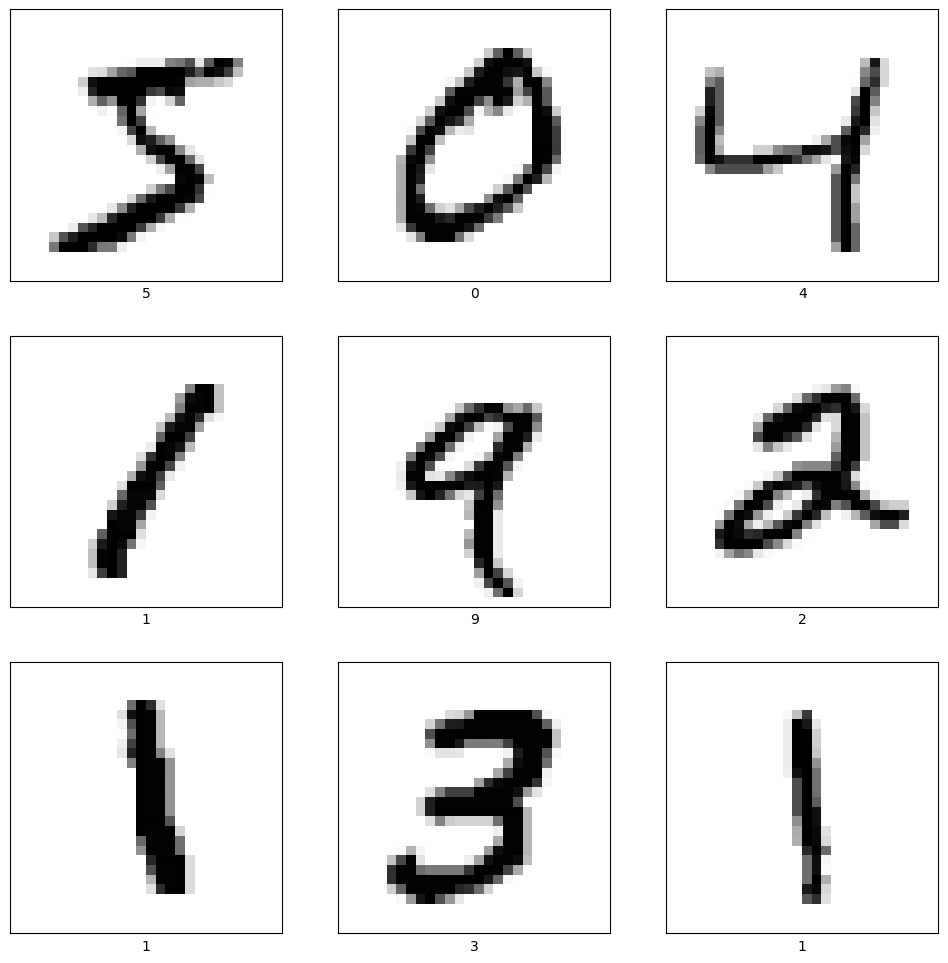

In [3]:
# Création d'une figure avec une taille de 12x12 pouces
plt.figure(figsize=(12, 12))

# Boucle pour afficher les neuf premières images avec leurs labels
for i in range(9):
    # Configuration d'un sous-graphique 3x3 avec l'index i + 1
    plt.subplot(3, 3, i + 1)
    
    # Désactivation des marques sur les axes x et y
    plt.xticks([])
    plt.yticks([])
    
    # Affichage de l'image X_train[i] en niveaux de gris
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    
    # Ajout du label y_train[i] en tant qu'étiquette de l'axe des abscisses
    plt.xlabel(y_train[i])

# Affichage de la figure contenant les sous-graphiques
plt.show()


## Prétraitement des données

Normaliser les valeurs de pixel des images en mettant à l'échelle entre 0 et 1, Cette étape divise toutes les valeurs de pixel par 255, Cela est fait pour standardiser les valeurs des pixels entre 0 et 1, ce qui est commun dans les tâches de prétraitement d'images 

In [4]:
X_train = X_train / 255
X_test = X_test / 255

Convertir les étiquettes en format catégorique (one-hot encoding), Maintenant, y_train et y_test sont convertis en représentation catégorique (vecteurs).

In [5]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Ce code utilise `ImageDataGenerator` pour générer des variations augmentées des images d'entraînement, y compris la rotation, le décalage horizontal/vertical, l'inclinaison et le zoom, afin d'enrichir le jeu de données et d'améliorer la robustesse du modèle lors de l'entraînement.

In [8]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1
)
datagen.fit(X_train)

##  Construction du modèle CNN 

Cette fonction `convolutional_model()` définit et compile un modèle de réseau de neurones convolutionnel (CNN) pour la classification d'images. Le modèle inclut des couches de convolution, de max pooling, d'aplatissement, de dense, et de sortie avec une activation softmax pour prédire les probabilités des classes.

In [17]:
def convolutional_model():

    # Initialisation d'un modèle séquentiel
    model = Sequential()

    # Ajout de la couche d'entrée avec une forme d'image de taille (28, 28, 1)
    model.add(Input(shape=(28, 28, 1)))

    # Ajout d'une couche de convolution avec 16 filtres de taille (5, 5), avec un pas de (1, 1) et une fonction d'activation ReLU
    model.add(Conv2D(16, (5, 5), strides=(1, 1), activation='relu'))

    # Ajout d'une couche de BatchNormalization pour la régularisation
    model.add(BatchNormalization())

    # Ajout d'une couche de max pooling pour réduire la taille spatiale de l'image avec un pool_size de (2, 2) et un pas de (2, 2)
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Aplatissement de la sortie de la couche précédente en un vecteur 1D ( On va passer de CNN vers MLP)
    model.add(Flatten())

    # Ajout d'une couche dense de 100 neurones avec une fonction d'activation ReLU
    model.add(Dense(100, activation='relu'))

    # Ajout d'une couche dense de sortie avec un nombre de neurones égal au nombre de catégories dans y_test, et une activation softmax pour obtenir des probabilités de classe
    model.add(Dense(y_test.shape[1], activation='softmax'))

    # Compilation du modèle avec l'optimiseur 'adam', la fonction de perte 'categorical_crossentropy' et la métrique d'évaluation 'accuracy'
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Retourne le modèle compilé
    return model



## Entrainement et Evaluation du modèle

Ce code crée, entraîne et évalue un modèle de convolution. Après l'entraînement, il affiche la précision du modèle sur les données de test.

In [18]:
# Création d'une instance de modèle de convolution
model = convolutional_model()

""" Entraînement du modèle avec les données d'entraînement (X_train et y_train)
et validation en utilisant les données de test (X_test et y_test).
Les paramètres :
- epochs : Nombre d'itérations complètes sur l'ensemble des données d'entraînement.
- batch_size : Nombre d'échantillons utilisés par mise à jour de gradient.
- verbose : Mode de verbosité (0 = silencieux, 1 = barre de progression, 2 = une ligne par époque)."""
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=12, batch_size=200, verbose=2) 

# Évaluation du modèle avec les données de test (X_test, y_test).
# La méthode evaluate() renvoie la perte (loss) et la précision (accuracy) sur les données de test.
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Affichage de la précision (accuracy) du modèle sur les données de test.
print("Test Accuracy:", test_accuracy)

Epoch 1/12
300/300 - 17s - 56ms/step - accuracy: 0.9535 - loss: 0.1519 - val_accuracy: 0.9743 - val_loss: 0.3946
Epoch 2/12
300/300 - 20s - 67ms/step - accuracy: 0.9863 - loss: 0.0419 - val_accuracy: 0.9836 - val_loss: 0.0507
Epoch 3/12
300/300 - 13s - 43ms/step - accuracy: 0.9921 - loss: 0.0252 - val_accuracy: 0.9827 - val_loss: 0.0566
Epoch 4/12
300/300 - 20s - 67ms/step - accuracy: 0.9953 - loss: 0.0153 - val_accuracy: 0.9872 - val_loss: 0.0452
Epoch 5/12
300/300 - 12s - 42ms/step - accuracy: 0.9964 - loss: 0.0113 - val_accuracy: 0.9889 - val_loss: 0.0393
Epoch 6/12
300/300 - 12s - 41ms/step - accuracy: 0.9971 - loss: 0.0083 - val_accuracy: 0.9874 - val_loss: 0.0448
Epoch 7/12
300/300 - 13s - 42ms/step - accuracy: 0.9973 - loss: 0.0083 - val_accuracy: 0.9862 - val_loss: 0.0508
Epoch 8/12
300/300 - 13s - 43ms/step - accuracy: 0.9961 - loss: 0.0111 - val_accuracy: 0.9872 - val_loss: 0.0509
Epoch 9/12
300/300 - 13s - 42ms/step - accuracy: 0.9980 - loss: 0.0058 - val_accuracy: 0.9873 - 

## Présentation des résultats

Ce code utilise un modèle de machine learning pour prédire les classes des données de test, puis affiche les images de test avec leurs classes réelles et prédites dans une grille. Il emploie `argmax` pour convertir les sorties du modèle en classes et visualise les résultats avec Matplotlib.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


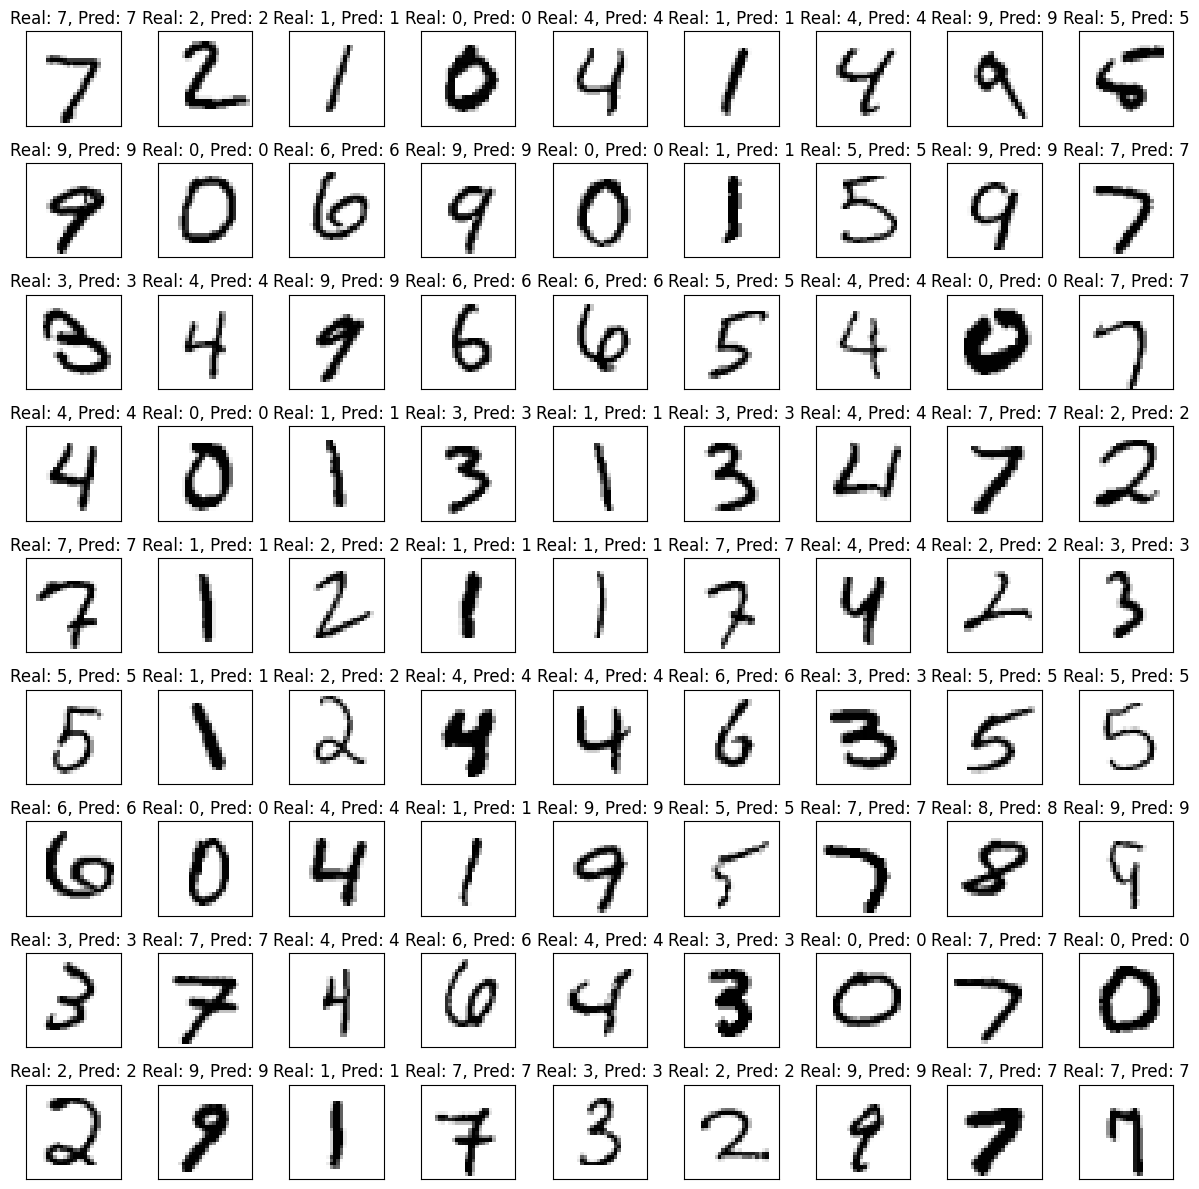

In [19]:
# Utilisation de la fonction argmax pour trouver les indices des valeurs maximales le long de l'axe des colonnes
# model.predict(X_test) effectue des prédictions sur X_test, puis np.argmax sélectionne l'indice de la classe prédite
predictions = np.argmax(model.predict(X_test), axis=-1)

# Utilisation de argmax pour convertir y_test en classes en trouvant l'indice de la valeur maximale le long de l'axe des colonnes
y_test_classes = np.argmax(y_test, axis=1)

# Définition des variables pour la mise en page de la figure
num_images = 81
num_rows = 9
num_cols = 9

# Création d'une figure avec une taille spécifique pour afficher les images de test
plt.figure(figsize=(12, 12))

# Boucle pour afficher chaque image de test avec sa véritable classe et sa prédiction
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)  # Sélection de la sous-trame dans la grille de visualisation
    plt.xticks([])  # Masquage des marques sur l'axe des x
    plt.yticks([])  # Masquage des marques sur l'axe des y
    plt.imshow(X_test[i].reshape(28, 28), cmap='binary')  # Affichage de l'image sous forme de matrice 28x28 en binaire
    # Affichage du titre indiquant la classe réelle et la prédiction pour chaque image
    plt.title(f"Real: {y_test_classes[i]}, Pred: {predictions[i]}", color='black')

plt.tight_layout()  # Ajustement automatique des subplots pour éviter le chevauchement
plt.show()  # Affichage de la figure contenant les images de test avec leurs prédictions

Ce code génère et affiche une matrice de confusion pour évaluer les performances d'un modèle de classification sur les données de test, puis imprime un rapport de classification qui résume la précision, le rappel et le score F1 pour chaque classe.

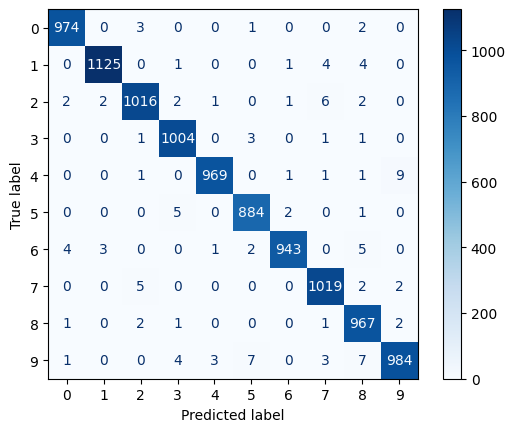

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.97      0.99      0.98       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [22]:
# Affichage de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_classes, predictions), display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.show()

report = classification_report(y_test_classes, predictions, target_names=[str(i) for i in range(10)])
print('Classification Report:')
print(report)